Using the seed 69
{'prompt': 'A painting of a sailing ship in a storm', 'height': 1152, 'width': 768, 'num_inference_steps': 20, 'negative_prompt': '', 'guidance_scale': 7.5}


100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


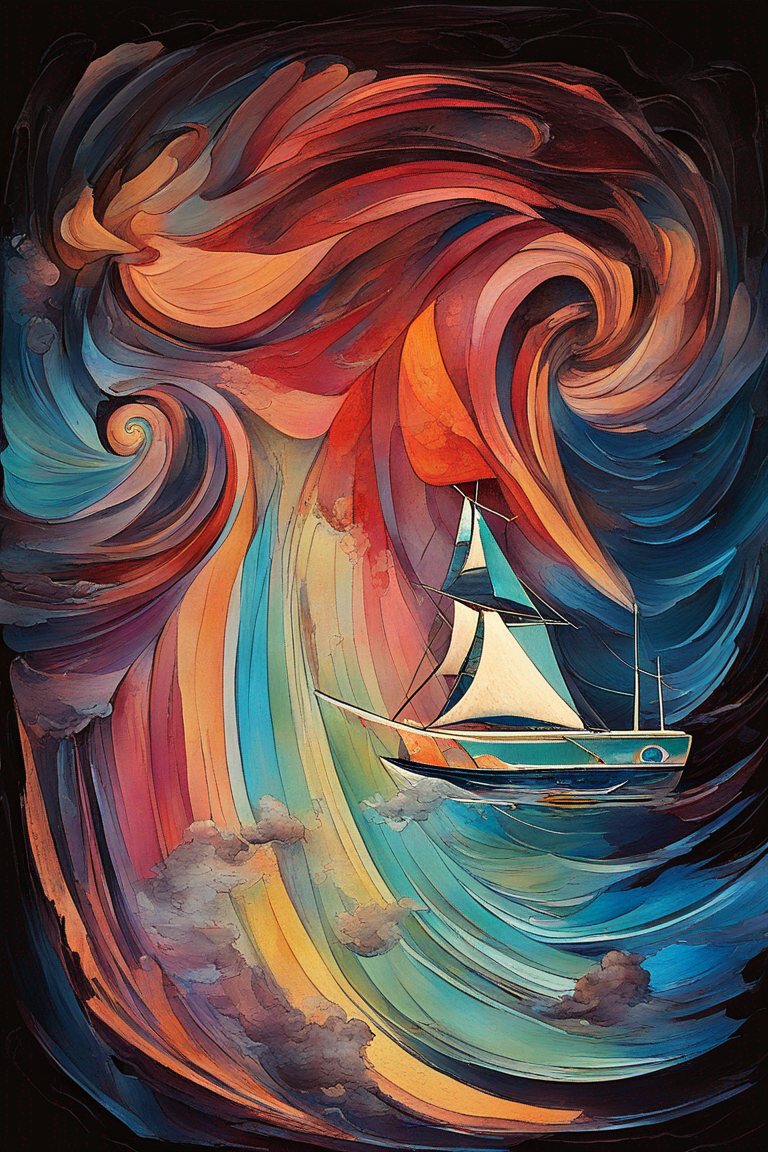

In [35]:
prompt = "A painting of a sailing ship in a storm" #@param{type:"string"}

negative = "" #@param{type: 'string'}
resolution = "Landscape 1152x768" #@param ["Custom (Select this and put width and height below)", "Square 512x512 (default, good for most models)", "Landscape 768x512", "Portrait 512x768", "Square 768x768 (good for 768 models)", "Landscape 1152x768", "Portrait 768x1152"] {type:"string"}
resolution =  "Custom (Select this and put width and height below)"

#@markdown <br>
#@markdown <b>Advanced Settings</b>
width_height_if_custom_is_selected = [768, 512] #@param{type: 'raw'}
width_height_if_custom_is_selected = [768, 1152]
steps = 20 #@param {type:"integer"}
samples_per_batch = 1
number_of_images = 1 #@param {type:"integer"}
seed = 69 #@param {type:"integer"}
guidance_scale = 7.5 #@param {type:"slider", min:0, max:20, step:0.5}
use_refiner = True #@param {type: "boolean"}
high_noise_frac = 0.8 #@param {type:"slider", min:0.1, max:0.9, step:0.1}

init_image = "" #@param {type:"string"}
init_image = "B:/Pictures/PS+NN/fuel/0_0.png"
add_noise_and_blur_to_image = False #@param {type: "boolean"}
img2img_strength = 0.75 #@param {type:"slider", min:0.1, max:1.0, step:0.05}

from IPython.display import display, clear_output
import requests

try:
  import torch
  from IPython.display import clear_output
  import diffusers
except ImportError as e:
  !pip install diffusers --upgrade
  !pip install transformers accelerate safetensors scipy
  !pip install invisible-watermark>=0.2.0 #lol, this isn't actually used in my implementation but i get yelled at if i don't install it

clear_output(wait=False)
import SimpleStableDiffusionXLPipeline
from diffusers import AutoencoderKL, DiffusionPipeline
import torch, random
import numpy as np
from datetime import datetime
import os
import PIL
from PIL import ImageFilter
from packaging import version

try:
    from diffusers.utils import PIL_INTERPOLATION
except ImportError:
    if version.parse(version.parse(PIL.__version__).base_version) >= version.parse("9.1.0"):
        PIL_INTERPOLATION = {
            "linear": PIL.Image.Resampling.BILINEAR,
            "bilinear": PIL.Image.Resampling.BILINEAR,
            "bicubic": PIL.Image.Resampling.BICUBIC,
            "lanczos": PIL.Image.Resampling.LANCZOS,
            "nearest": PIL.Image.Resampling.NEAREST,
        }
    else:
        PIL_INTERPOLATION = {
            "linear": PIL.Image.LINEAR,
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
            "nearest": PIL.Image.NEAREST,
        }


def set_seed(seed, display_text=True):
    seed = random.randint(0, 2**32) if seed < 0 else seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if display_text:
        print(f"Using the seed {seed}")
    return seed

def load_img(path, shape, add_noise = False):
    if path.startswith('http://') or path.startswith('https://'):
        image = PIL.Image.open(requests.get(path, stream=True).raw).convert('RGB')
    else:
        if os.path.isdir(path):
            files = [file for file in os.listdir(path) if file.endswith(
                '.png') or file .endswith('.jpg')]
            path = os.path.join(path, random.choice(files))
            print(f"Chose random init image {path}")
        image = PIL.Image.open(path).convert('RGB')
    image = image.resize(shape, resample=PIL_INTERPOLATION["lanczos"])
    if add_noise:
      image = image.filter(ImageFilter.GaussianBlur(radius=20))
    image = np.array(image).astype(np.float16) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    if add_noise:
      noise = np.random.normal(loc=0, scale=1, size=image.shape)
      image = np.clip((image + noise*0.3),0,1)
    image = torch.from_numpy(image)
    return 2.*image - 1.

try:
  pipe
except NameError as e:
  vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
  pipe = DiffusionPipeline.from_pretrained(
      "stabilityai/stable-diffusion-xl-base-1.0", vae=vae, custom_pipeline="SimpleStableDiffusionXLPipeline", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
  )
  pipe.to("cuda")
  clear_output(wait=False)

if use_refiner:
  try:
    refiner
  except NameError as e:
    refiner = DiffusionPipeline.from_pretrained(
      "stabilityai/stable-diffusion-xl-refiner-1.0",
      text_encoder_2=pipe.text_encoder_2,
      vae=vae,
      torch_dtype=torch.float16,
      use_safetensors=True,
      variant="fp16",
      )
    refiner.to("cuda")
    clear_output(wait=False)



res_dict = {"Square 512x512 (default, good for most models)": [512,512],
            "Landscape 768x512": [768,512],
            "Portrait 512x768": [512,768],
            "Square 768x768 (good for 768 models)": [768,768],
            "Landscape 1152x768": [1152,768],
            "Portrait 768x1152":[768,1152]}

width, height = width_height_if_custom_is_selected if resolution == "Custom (Select this and put width and height below)" else res_dict[resolution]
seed = random.randint(0, 2**32) if seed < 0 else seed
set_seed(seed)

try:
  for x in range(number_of_images):
    prompt_options = {
        "prompt": prompt,
        "height": height,
        "width": width,
        "num_inference_steps": steps,
        "negative_prompt": negative,
        "guidance_scale": guidance_scale
    }
    print(prompt_options)

    if init_image != "":
      try:
        prompt_options["image"] = load_img(init_image, shape=(width, height), add_noise = add_noise_and_blur_to_image)
        prompt_options["strength"] = img2img_strength
      except Exception as e:
        print(f"Sorry, couldn't load image, trying without img2img!\n{e}")


    if use_refiner:
      prompt_options["output_type"] = "latent"
      prompt_options["denoising_end"] = high_noise_frac

      refiner_options = {
        "prompt": prompt,
        "num_inference_steps": steps,
        "negative_prompt": negative,
        "guidance_scale": guidance_scale,
        "denoising_start": high_noise_frac,
      }

    if x < number_of_images - 1:
      seed += 1
      set_seed(seed)

    image = pipe(**prompt_options).images[0]

    if use_refiner:
      refiner_options["image"] = image
      image = refiner(**refiner_options).images[0]

    display(image)
    image.save( f"outputs/{datetime.now().strftime('%Y_%m_%d_%H%M%S')}_{seed}.png")
except Exception as e:
  print(f"An error has occured! Please tell @Cadaeic the following: \n{e}")